*Luis Antonio Ortega Andrés     
Antonio Coín Castro*

# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

Funciones auxiliares para visualizar información:

In [3]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0: 
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X " 
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      color = "\033[0m"
      if world.map[(i, j)] == -1:
        p += color + " # "
      elif world.map[(i, j)] == 1:
        p += color + " @ "
      else:
        if world.map[(i, j)] == 2:
            color = "\033[94m"
        if policy[i][j] == 0:
            p += color + " ^ "
        elif policy[i][j] == 1:
            p += color + " v "
        elif policy[i][j] == 2:
            p += color + " < "
        else:
            p += color + " > "
    p += "\n"
  print(p)

# Clase *World*: 

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1), agujeros de gusano (2) y celdas terminales (1).
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto).

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Lista de agujeros de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él.
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo.

Por ejemplo: 

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

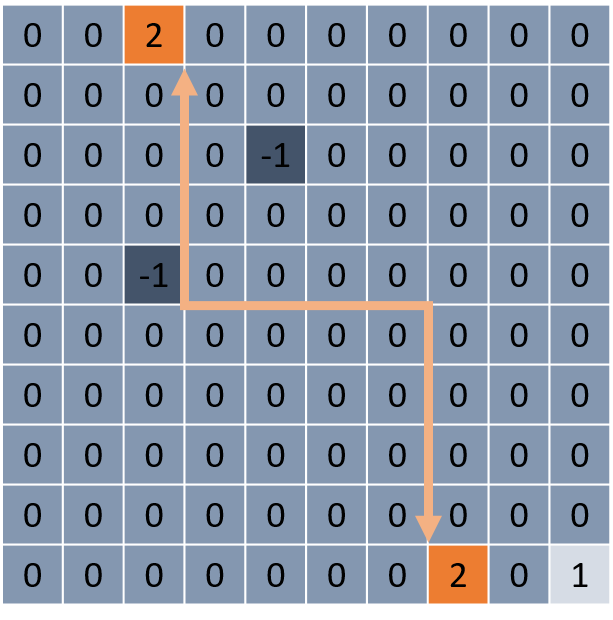

In [4]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        # Estados con agujeros de gusano
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2
        self.holes = np.array(hole)

  def is_goal(self, state):
    return self.map[(state[0], state[1])] == 1

  def is_obstacle(self, state):
    return self.map[(state[0], state[1])] == -1

Prueba de la clase *World*:

In [5]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*. 

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*. No modifica el estado interno.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*. No modifica el estado interno.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

## Comportamiento inicial (Agent)

- Si se va a salir del mapa, rebota, recibiendo un refuerzo neutro.
- Si entra a un agujero de gusano, sale siempre por otro, que será el más cercano a la meta (en caso de haber más de dos), recibiendo un refuerzo neutro.
- Si entra en una casilla con obstáculo, recibe un refuerzo negativo, y además ya nunca puede salir de él.

## Cambio en los obstáculos (Agent2)

Se edita el comportamiento para que al entrar a un obstáculo, el agente rebote en vez de quedarse estancado para siempre.

## Cambio en los refuerzo (Agent3)

Damos a las casillas vacías refuerzos de -0.1 en lugar de 0, para de esta forma intentar que el agente encuentre el camino más corto a la salida. Además, incrementamos a -2 el refuerzo de los obstáculos, para que sea mucho más perjudicial ir a ninguno de ellos que avanzar por casillas vacías. No modificamos el comportamiento en los obstáculos.

## Combianción de ambos cambios (Agent4)

Se combinan los cambios de los dos agentes anteriores.

In [6]:
class Agent:
  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if (self.world.map[(i, j)] == 2 and 
            (nextState[0] != i and nextState[1] != j)):
            aux = np.array([i, j])
      nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # 
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = 0 
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1: 
      nextState = state                            
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1: 
      nextState = self.state     
    else: 
      self.state = nextState                                 
    reward = self.reward(nextState)
    return self.state, reward 

  def is_terminal(self, state):
    return self.world.is_goal(state) or self.world.is_obstacle(state) 


class Agent2(Agent):
  def __init__(self, world, initialState):
    super().__init__(world, initialState)

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    reward = self.reward(nextState)
    if self.world.map[(nextState[0], nextState[1])] == -1: 
      nextState = state                            
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    reward = self.reward(nextState)
    if self.world.map[(nextState[0], nextState[1])] != -1: 
      self.state = nextState                                 
    return self.state, reward

  def is_terminal(self, state):
    return self.world.is_goal(state)


class Agent3(Agent):
  def __init__(self, world, initialState):
    super().__init__(world, initialState)

  def reward(self, nextState):
    # Modifica refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -2
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = -0.1 
    return reward

class Agent4(Agent2, Agent3):
  def __init__(self, world, initialState):
    self.world = world
    self.state = np.array(initialState)

Prueba de la clase *Agent*:

In [7]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente hacia la meta pasando por el teletransporte
  print("Ruta desde [(0, 0)]:")
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

 O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F 

Ruta desde [(0, 0)]:
(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos: 

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [8]:
if __name__ == "__main__":
  
  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]          
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
 O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F 

World 1: 
 O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X 

## Funciones globales

Implementamos a continuación el esqueleto de nuestras funciones de *value-learning*. La idea general es que tras el bucle de entrenamiento hacemos testing de nuestra política, y si con la política actual (determinista, sin considerar acciones aleatorias de exploración) se resuelve el problema, consideramos que ha convergido y detenemos el entrenamiento.

Sin embargo, como en algunos agentes (el 3 y el 4) estamos interesados en ver si se puede encontrar el camino más corto, tras alcanzar la convergencia consideramos unos cuantos episodios extra de optimización, donde se intenta ver si prosiguiendo con el entrenamiento se consigue disminuir la longitud del camino encontrado.

In [9]:
INITIAL_STATE = (0, 0)
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
SEED = 2021

In [10]:
from IPython.display import clear_output
import time

def choose_action_egreedy(Q, S, rng, epsilon, actions):
    if rng.random() < epsilon:
        # Choose a random action
        return rng.choice(len(actions))
    else:
        # Randomly choose a maximal action
        actions_value = Q[S[0], S[1], :]
        return rng.choice(
            np.where(actions_value == np.max(actions_value))[0])


def build_policy(world, Q):
    policy = np.zeros(world.size, dtype = np.int8)
    for i in range(world.size[0]):
        for j in range(world.size[1]):
            policy[i, j] = np.argmax(Q[i, j, :])
    return policy


def test_policy(policy, world, agent, actions):
    """Test a policy. Return wether the agent reaches the goal,
       in how many steps (-1 if not), and the accumulated reward."""
    state = agent.state
    accum_R = 0

    # If it doesn't reach the goal in HxW steps, it is cycling
    for step in range(world.size[0]*world.size[1]):
        if world.is_goal(state):
            return True, step, accum_R

        action_idx = policy[state[0], state[1]]
        action = actions[action_idx]
        state, R = agent.checkAction(state, action)
        accum_R += R

    return False, -1, accum_R


def optimization_episode(Q, episode, world, agent, actions, 
                         alpha, epsilon, gamma, decay,
                         decay_interval, rng, step_funct, 
                         verbose, max_steps):
    # Initialize state
    S = agent.state

    # Choose action based on Q(S,-)
    A_idx = choose_action_egreedy(Q, S, rng, epsilon, actions)
    A = actions[A_idx]

    # Loop until reaching a terminal state
    for step in range(max_steps):
        if agent.is_terminal(S):
            break

        # Observe next state and choose next action accordingly 
        nextState, R = agent.checkAction(S, A)
        nextAction_idx = choose_action_egreedy(
            Q, nextState, rng, epsilon, actions)
        nextAction = actions[nextAction_idx]

        # Update Q
        Q[S[0], S[1], A_idx] = step_funct(Q, R, S, alpha, gamma, 
                                          nextState, nextAction_idx, 
                                          A_idx)
            
        # Advance step
        S = nextState
        A = nextAction
        A_idx = nextAction_idx
 
    # Epsilon decay
    if episode % decay_interval == 0 and epsilon > 0.001:
        epsilon *= decay

    # Policy test
    policy = build_policy(world, Q)
    
    if verbose:
        clear_output()
        print(f"Episode {episode + 1}")
        printPolicy(world, policy)
        time.sleep(1)

    converged, path_length, reward = \
        test_policy(policy, world, agent, actions)

    return converged, path_length, reward


def value_learning(world, agent, actions, alpha, epsilon, 
                   gamma, decay, decay_rate, n_episodes, 
                   seed, optimize_steps, step_funct, 
                   verbose, max_steps):
    if decay < 1.0:
        decay_interval = int(n_episodes/decay_rate)
    else:
        decay_interval = n_episodes

    # Initialization
    Q = np.zeros((*world.size, len(actions)))  # H x W x |A|
    rng = np.random.default_rng(seed)
    converged = False
    total_R = []
    paths = []

    # Loop through episodes
    for episode in range(n_episodes):
        converged, path_length, reward = \
            optimization_episode(Q, episode, world, agent, actions, 
                                 alpha, epsilon, gamma,
                                 decay, decay_interval,
                                 rng, step_funct, verbose, max_steps)
        paths.append(path_length)
        total_R.append(reward)
        
        if converged:
            print(f"Converged in {episode + 1} episodes. "
                  f"Path length: {path_length}")
            save_Q = Q.copy()
            best_path_length = path_length
            break

    episodes = episode + 1

    if converged:
        for opt_episode in range(optimize_steps):
            converged_opt, path_length_opt, _ = \
                optimization_episode(Q, episode, world, agent, actions, 
                                     alpha, epsilon, gamma, 
                                     decay, decay_interval, rng,
                                     step_funct, False, max_steps)

            if converged_opt and path_length_opt < best_path_length:
                save_Q = Q.copy()
                best_path_length = path_length_opt
                episodes = episode + opt_episode + 2
                print(f"Improved path length: {best_path_length} "
                      f"({episodes} episodes in total)")

        Q = save_Q
    else:
        print(f"Did not converge after {episodes} episodes")
        best_path_length = -1
    
    return Q, episodes, converged, best_path_length, paths, total_R


def policy(world, agent=None, alpha=0.1, epsilon=0.2, gamma=1.0, 
           decay=1.0, decay_rate=10, n_episodes=500, optimize_steps=100,
           step_funct = None, verbose=False, max_steps=1000):
    if agent == 2:
        agent = Agent2(world, INITIAL_STATE)
    elif agent == 3:
        agent = Agent3(world, INITIAL_STATE)
    elif agent == 4:
        agent = Agent4(world, INITIAL_STATE)
    else:
        agent = Agent(world, INITIAL_STATE)

    # Learn value function Q
    Q, episodes, converged, path_length, paths, total_R = \
        value_learning(world, agent, ACTIONS, alpha, 
                       epsilon, gamma, decay, decay_rate,
                       n_episodes, SEED, optimize_steps, 
                       step_funct, verbose, max_steps)

    # Compute policy based on Q
    policy = build_policy(world, Q)

    return policy, Q, episodes, converged, paths, total_R, path_length

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

Dado el esqueleto de arriba, solo tenemos que implementar la función de actualización de Q según SARSA, que sería el parámetro `step_funct` de la función de entrenamiento.

In [11]:
def SARSA_optimization(Q, R, S, alpha, gamma, nextState, nextAction_idx, A_idx):
    return (Q[S[0], S[1], A_idx] 
            + alpha*(R + gamma*Q[nextState[0], nextState[1], nextAction_idx] 
            - Q[S[0], S[1], A_idx]))

A continuación hacemos pruebas en todos los mapas con los diferentes agentes considerados. Hacemos una serie de consideraciones generales:

- A la hora de visualizar las políticas, pintamos los obstáculos con '#', la meta con '@', y los túneles de color azul.
- Para los mapas pequeños hemos activado el modo "interactivo" con `verbose=True`, de forma que se puede ver cómo se actualiza la política episodio a episodio si se ejecuta.
- En los mapas grandes aumentamos el número máximo de pasos por episodio, para dejar que el agente haga un recorrido más largo en cada episodio.

### Pruebas con la configuración original

#### Mapa 1

In [87]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.1, epsilon=0.0, n_episodes=100,
    optimize_steps=10, step_funct = SARSA_optimization,
    verbose = True
)

Episode 32
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 32 episodes. Path length: 16


In [59]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.0, n_episodes=5000, 
    step_funct = SARSA_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 180 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [60]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.1, epsilon=0.01,
    n_episodes=50000, step_funct = SARSA_optimization
)
printPolicy(w1g, policy_w1g)

Converged in 27657 episodes. Path length: 240
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  

#### Mapa 2

In [99]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100,
    step_funct = SARSA_optimization, verbose=True
)

Episode 8
 v  ^  ^  ^  ^ 
 v  ^  ^  ^  ^ 
 ^  ^  v  #  ^ 
 ^  ^  >  v  ^ 
 ^  ^  >  >  @ 

Converged in 8 episodes. Path length: 4


In [62]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = SARSA_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 52 episodes. Path length: 8
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  #  ^  ^  #  ^  ^  ^  #  ^ 
 >  v  #  ^  v  ^  ^  ^  v  ^ 
 ^  ^  v  ^  ^  #  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  v  #  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  v  ^  #  ^ 
 ^  v  #  ^  ^  ^  ^  >  v  v 
 ^  ^  v  ^  ^  ^  v  #  >  v 
 ^  ^  ^  ^  ^  ^  >  >  >  @ 



In [63]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, 
    step_funct = SARSA_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 134 episodes. Path length: 16
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  #  #  ^  ^  ^  ^ 
 >  v  v  ^  #  ^  ^  ^  ^  ^  ^  ^  #  #  v  ^  #  #  #  ^  ^ 
 ^  v  ^  ^  <  #  #  ^  ^  ^  #  ^  v  v  ^  ^  ^  #  ^  ^  ^ 
 ^  v  ^  ^  #  v  #  #  ^  ^  v  #  ^  ^  #  ^  #  ^  ^  ^  ^ 
 ^  >  v  ^  v  ^  v  v  #  ^  ^  v  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  ^  ^  v  ^  #  ^  ^  ^  v  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  #  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  v  v  ^  ^  ^  ^  #  #  ^  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  #  ^  ^  v  #  ^  ^  ^  #  ^  #  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  <  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  v  #  ^  ^  #  #  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  v  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  

#### Mapa 3

In [100]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = SARSA_optimization, verbose=True
)

Episode 18
 v  ^  ^  ^  v 
 v  #  ^  ^  v 
 v  <  ^  #  v 
 v  #  ^  ^  v 
 ^  ^  ^  ^  @ 

Converged in 18 episodes. Path length: 8


In [68]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = SARSA_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 73 episodes. Path length: 20
 v  ^  >  v  ^  ^  ^  ^  ^  ^ 
 v  ^  ^  >  v  ^  ^  ^  ^  ^ 
 >  >  >  ^  >  v  #  v  ^  ^ 
 ^  ^  ^  ^  #  >  >  v  #  ^ 
 ^  ^  ^  #  >  ^  >  v  #  ^ 
 ^  ^  ^  v  #  ^  ^  >  v  < 
 ^  ^  #  ^  <  #  v  ^  v  ^ 
 ^  ^  v  ^  #  v  v  ^  v  ^ 
 ^  ^  ^  #  v  ^  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  @ 



In [71]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.0, n_episodes=1000, 
    step_funct = SARSA_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 366 episodes. Path length: 40
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  #  ^  ^  ^ 
 >  v  ^  v  ^  ^  v  ^  ^  #  ^  ^  ^  ^  ^  #  v  <  ^  ^  ^ 
 ^  v  v  <  v  >  v  ^  ^  #  #  ^  #  ^  #  v  ^  #  ^  ^  ^ 
 ^  >  >  >  >  >  >  v  v  v  v  #  v  ^  v  ^  ^  #  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  ^  >  >  >  v  #  ^  #  ^  ^  ^  v  ^  ^  ^ 
 ^  v  ^  ^  #  ^  ^  #  ^  v  v  v  ^  v  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  ^  #  v  ^  >  >  v  #  ^  ^  v  ^  ^  v  <  ^ 
 ^  ^  ^  ^  ^  ^  <  ^  ^  ^  #  v  #  ^  ^  ^  ^  #  v  ^  ^ 
 ^  ^  ^  ^  #  ^  #  >  v  #  v  v  v  #  #  #  ^  <  >  >  v 
 ^  ^  ^  ^  v  >  >  >  >  >  >  v  ^  v  <  v  ^  #  ^  ^  v 
 ^  ^  ^  ^  ^  ^  ^  ^  >  ^  #  v  <  ^  #  ^  ^  v  ^  ^  v 
 ^  ^  ^  ^  ^  ^  #  ^  ^  ^  v  v  #  v  v  #  ^  ^  #  ^  v 
 ^  ^  ^  #  #  ^  #  ^  ^  >  >  v  >  v  v  <  ^  ^  v  >  v 
 ^  ^  ^  v  #  #  >  ^  ^  ^  #  v  ^  >  v  ^  ^  ^  v  ^  

#### Mapa 4

In [73]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.01, n_episodes=10000, 
    step_funct=SARSA_optimization
)
printPolicy(w4, policy_w4)

Converged in 4819 episodes. Path length: 82
 v  #  v  #  >  >  >  <  v  #  ^  ^  ^  ^  ^  #  #  #  ^  #  v 
 v  #  v  #  #  #  #  #  v  #  #  #  #  #  ^  >  ^  #  v  #  ^ 
 v  #  >  >  v  <  <  <  <  #  ^  <  v  #  ^  #  #  #  v  #  ^ 
 v  #  ^  #  v  #  v  #  ^  #  ^  #  ^  <  ^  <  #  v  <  #  ^ 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  v  #  v  #  #  v 
 #  #  #  #  v  #  >  >  v  #  >  >  >  >  <  <  #  >  >  >  < 
 >  >  >  >  v  #  #  #  ^  #  #  #  #  #  #  ^  #  #  v  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  >  v  <  <  <  <  <  <  <  #  v 
 v  <  <  #  v  <  <  #  #  #  v  <  #  #  #  #  #  #  #  #  ^ 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  >  >  >  >  >  v  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  >  >  v 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  >  v  #  #  #  > 
 v  #  ^  <  <  #  #  ^  #  #  v  #  v  #  >  >  >  >  v  #  ^ 
 v  #  #  #  #  #  >  ^  #  v  >  >  >  >  ^  #  #  #  v  #  ^ 
 >  >  >  v  #  >  ^  #  #  v  #  ^  #  #  ^  #  v  <  <  # 

### Pruebas cambiando el comportamiento en obstáculos

#### Mapa 1

In [101]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    optimize_steps=10, step_funct = SARSA_optimization,
    verbose=True
)

Episode 16
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 16 episodes. Path length: 16


In [75]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.0, n_episodes=5000, agent=2, 
    step_funct = SARSA_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 119 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [86]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.2, epsilon=0.1, agent=2, decay=0.5, max_steps=10000,
    n_episodes=50000, step_funct = SARSA_optimization
)
printPolicy(w1g, policy_w1g)

Converged in 435 episodes. Path length: 240
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  # 

#### Mapa 2

In [103]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = SARSA_optimization, verbose=True
)

Episode 7
 v  ^  ^  ^  ^ 
 v  ^  ^  ^  ^ 
 ^  ^  v  #  ^ 
 ^  ^  >  v  ^ 
 ^  ^  >  >  @ 

Converged in 7 episodes. Path length: 4


In [104]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = SARSA_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 10 episodes. Path length: 8
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  #  #  ^  #  ^  ^  ^  ^  ^ 
 >  v  <  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  ^  v  ^  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  ^  #  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  >  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  >  >  @ 



In [105]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=2,
    step_funct = SARSA_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 39 episodes. Path length: 18
 v  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  v  ^  ^  ^  ^ 
 ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^  ^ 
 ^  v  >  v  ^  ^  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  >  v  <  #  ^  ^  v  ^  ^  #  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  >  ^  #  v  ^  ^  ^  ^  ^  v  ^  ^  <  ^  ^  #  v  ^  ^  ^ 
 ^  #  ^  #  ^  ^  #  ^  ^  ^  ^  #  ^  #  ^  ^  v  ^  ^  ^  ^ 
 ^  v  ^  v  #  ^  v  #  ^  ^  #  v  ^  #  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  v  ^  ^  <  ^  ^  v  v  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  #  ^  ^  ^  #  ^  #  ^  ^  ^  ^  v  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  v  #  #  ^  v  ^  v  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  #  ^  v  v  ^  ^  ^  ^  v  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^ 
 ^  #  ^  v  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^

#### Mapa 3

In [106]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = SARSA_optimization, verbose=True
)

Episode 10
 v  ^  ^  ^  v 
 v  #  ^  ^  v 
 v  <  ^  #  v 
 v  #  ^  >  v 
 ^  v  ^  ^  @ 

Converged in 10 episodes. Path length: 8


In [107]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = SARSA_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 39 episodes. Path length: 18
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  v  ^  ^  ^  ^  ^  >  ^  ^ 
 >  v  >  v  #  ^  ^  ^  ^  ^ 
 ^  >  >  >  v  v  ^  ^  ^  ^ 
 ^  ^  #  >  >  v  #  ^  ^  ^ 
 ^  ^  #  ^  ^  v  #  #  ^  ^ 
 ^  v  v  v  ^  >  >  v  ^  ^ 
 >  >  >  >  >  >  >  >  v  < 
 ^  >  >  >  ^  ^  ^  #  v  ^ 
 ^  ^  ^  ^  ^  ^  ^  >  >  @ 



In [108]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=2,
    step_funct = SARSA_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 201 episodes. Path length: 44
 >  >  v  ^  v  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  >  >  >  >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  >  ^  #  ^  ^  v  ^  #  ^  #  #  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  v  v  <  v  ^  #  ^  v  v  ^  ^  ^  #  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  >  >  v  ^  #  ^  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^ 
 ^  #  ^  >  v  v  <  ^  <  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  >  v  ^  ^  #  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  ^  >  v  ^  #  #  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  v  ^  <  v  ^  ^  ^  v  ^  #  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  >  >  v  #  ^  ^  ^  #  ^  ^  v  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  #  v  v  ^  ^  ^  v  ^  ^  ^  v  v  #  ^  v  < 
 ^  ^  #  ^  ^  v  v  v  v  ^  v  <  ^  #  ^  >  >  >  v  <  ^ 
 ^  #  #  #  ^  ^  v  v  <  ^  v  ^  ^  v  ^  ^  ^  >  >  v  v 
 ^  v  v  #  ^  >  >  v  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  v  < 
 ^  ^  ^  v  ^  ^  ^  v  #  ^  v  <  ^  #  ^  ^  ^  ^  ^  v  

#### Mapa 4

In [112]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.2, decay=0.8, n_episodes=10000, agent=2,
    step_funct=SARSA_optimization
)
printPolicy(w4, policy_w4)

Converged in 377 episodes. Path length: 84
 v  #  v  #  >  >  >  <  v  #  >  >  >  >  v  #  #  #  ^  #  v 
 v  #  v  #  #  #  #  #  v  #  #  #  #  #  v  <  <  #  v  #  v 
 v  #  >  >  v  <  <  <  <  #  >  >  v  #  v  #  #  #  v  #  v 
 v  #  ^  #  v  #  ^  #  ^  #  ^  #  >  >  >  v  #  v  <  #  ^ 
 >  >  ^  #  v  #  ^  #  #  #  #  #  #  #  #  ^  #  v  #  #  v 
 #  #  #  #  v  #  >  <  <  #  >  <  >  >  >  v  #  >  >  >  v 
 >  >  >  >  v  #  #  #  ^  #  #  #  #  #  #  v  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  v  v  >  >  >  >  >  >  ^  #  ^ 
 v  <  <  #  v  <  <  #  #  #  >  <  #  #  #  #  #  #  #  #  ^ 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  v  <  <  <  >  <  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  v  ^  #  #  #  #  ^  >  < 
 v  #  ^  #  v  #  >  >  ^  #  v  #  v  #  #  >  v  #  #  #  > 
 v  #  ^  <  <  #  #  ^  #  #  v  #  v  #  >  ^  >  >  v  #  ^ 
 v  #  #  #  #  #  >  ^  #  >  >  >  >  >  ^  #  #  #  v  #  ^ 
 >  >  >  v  #  >  ^  #  #  ^  #  ^  #  #  ^  #  v  <  <  #  

### Pruebas cambiando los refuerzos del agente

#### Mapa 1

In [131]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.5, epsilon=0.1, decay=0.8, n_episodes=100, agent=3,
    optimize_steps=10, step_funct = SARSA_optimization,
    verbose=True
)

Episode 41
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 41 episodes. Path length: 16


In [255]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.4, decay=0.9, gamma=0.8, n_episodes=10000, agent=3, 
    max_steps=2000, step_funct = SARSA_optimization
)
printPolicy(w1m, policy_w1m)

Did not converge after 10000 episodes
 ^  #  ^  >  ^  #  ^  ^  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  v  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  <  <  #  ^  ^  ^  #  @ 



In [140]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.2, epsilon=0.1, agent=3, decay=0.8, max_steps=10000,
    n_episodes=50000, step_funct = SARSA_optimization
)
printPolicy(w1g, policy_w1g)

Did not converge after 50000 episodes
 >  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 >  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 >  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 <  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 <  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v

#### Mapa 2

In [142]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=3,
    step_funct = SARSA_optimization, verbose=True
)

Episode 16
 v  v  <  >  < 
 v  >  ^  >  ^ 
 <  <  ^  #  ^ 
 ^  v  <  v  v 
 <  ^  >  >  @ 

Converged in 16 episodes. Path length: 4


In [143]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=3,
    step_funct = SARSA_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 54 episodes. Path length: 8
 v  >  >  v  <  >  ^  <  v  < 
 v  #  #  v  #  ^  ^  ^  >  v 
 v  <  <  ^  #  v  <  ^  v  ^ 
 >  ^  >  ^  <  >  ^  <  <  > 
 <  ^  #  v  #  v  >  ^  <  < 
 <  <  #  ^  v  >  ^  ^  #  > 
 v  >  >  <  <  v  ^  #  v  > 
 ^  v  >  ^  ^  v  #  >  ^  v 
 >  v  v  <  ^  <  v  v  v  v 
 <  <  v  v  v  ^  >  >  >  @ 



In [144]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=3,
    step_funct = SARSA_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 345 episodes. Path length: 16
 >  v  >  v  <  >  >  v  v  <  v  v  >  v  >  ^  >  <  v  <  > 
 v  v  >  v  >  v  >  ^  v  v  <  <  v  v  >  ^  #  ^  <  v  v 
 >  >  v  v  ^  ^  <  <  >  >  ^  <  >  v  #  v  >  ^  ^  ^  < 
 ^  <  v  v  v  >  ^  ^  v  v  v  <  <  <  >  v  ^  >  ^  >  > 
 v  >  v  <  ^  <  ^  #  >  <  >  <  v  #  v  >  v  <  v  ^  v 
 v  >  v  <  #  v  >  v  >  <  #  v  ^  #  >  v  v  #  ^  ^  < 
 v  ^  ^  #  >  v  >  v  ^  v  v  <  v  >  <  v  #  >  v  <  v 
 ^  #  v  #  >  v  #  ^  <  v  <  #  v  #  ^  ^  <  <  >  ^  < 
 >  <  v  v  #  ^  v  #  ^  <  #  v  <  #  #  v  v  <  ^  >  < 
 <  >  v  v  #  v  <  v  <  ^  >  >  >  v  v  <  <  #  >  v  ^ 
 v  v  ^  >  >  <  #  ^  ^  <  #  <  #  >  >  >  v  >  v  ^  ^ 
 ^  v  <  ^  #  <  ^  #  #  >  v  >  <  #  ^  >  >  >  v  <  < 
 v  >  <  >  ^  #  >  <  ^  v  v  >  v  >  ^  #  ^  >  >  <  < 
 >  ^  <  #  <  <  >  v  v  <  >  <  <  ^  >  v  >  ^  ^  v  ^ 
 v  #  >  ^  v  >  <  v  ^  >  #  v  <  <  <  ^  <  v  ^  v  

#### Mapa 3

In [158]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.01, n_episodes=100, agent=3,
    step_funct = SARSA_optimization, verbose=True
)
printPolicy(w3p, policy_w3p)

Episode 29
 v  <  >  >  < 
 v  #  >  ^  v 
 >  >  ^  #  v 
 <  #  v  v  v 
 >  >  >  >  @ 

Converged in 29 episodes. Path length: 12
Improved path length: 8 (40 episodes in total)
 >  >  v  v  ^ 
 v  #  >  >  v 
 ^  >  v  #  v 
 v  #  v  v  v 
 >  >  >  >  @ 



In [165]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=3,
    step_funct = SARSA_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 153 episodes. Path length: 22
Improved path length: 20 (235 episodes in total)
Improved path length: 18 (245 episodes in total)
 v  >  <  >  v  >  >  v  v  > 
 v  v  >  v  >  v  v  >  v  v 
 >  >  v  ^  #  ^  >  >  >  v 
 v  v  >  >  v  >  >  >  >  v 
 ^  <  #  v  v  ^  #  >  >  v 
 v  v  #  ^  >  v  #  #  >  v 
 >  >  v  >  >  >  v  >  >  v 
 <  v  ^  >  >  >  >  >  >  v 
 ^  v  v  v  v  v  v  #  v  v 
 v  v  >  >  >  >  >  >  >  @ 



In [174]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.1, decay=0.8, n_episodes=10000,
    max_steps=5000, agent=3, step_funct = SARSA_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 1817 episodes. Path length: 42
 >  >  v  >  >  >  <  <  >  >  ^  v  v  v  >  >  >  >  v  <  > 
 v  >  >  >  v  >  >  <  <  >  ^  ^  >  ^  >  >  <  ^  v  <  > 
 <  >  v  #  v  <  v  ^  #  v  #  #  v  >  >  <  ^  v  v  >  > 
 v  #  v  v  >  >  v  v  #  >  v  >  ^  >  ^  #  v  >  v  >  ^ 
 v  #  ^  >  <  <  v  v  #  >  ^  >  <  ^  #  v  <  v  >  v  v 
 ^  #  v  v  <  v  v  >  >  >  >  v  >  #  >  v  v  ^  v  v  < 
 <  #  v  v  >  v  >  ^  #  >  v  v  #  v  <  <  >  ^  ^  >  v 
 v  >  >  v  >  v  v  #  #  v  v  v  #  >  <  <  >  v  v  <  v 
 v  v  v  <  v  <  >  >  >  >  >  >  v  v  #  #  v  >  ^  <  v 
 <  >  >  ^  v  ^  v  #  v  v  v  #  >  v  v  #  >  >  v  >  v 
 ^  ^  >  >  v  #  >  v  <  >  <  v  ^  >  v  <  ^  #  v  v  v 
 >  <  #  ^  ^  <  ^  >  v  <  v  >  v  #  v  <  >  v  v  >  v 
 v  #  #  #  ^  ^  v  ^  >  v  >  v  >  v  v  v  v  v  v  >  v 
 >  <  v  #  >  >  <  v  ^  v  ^  v  v  >  >  >  >  v  v  >  v 
 >  v  v  v  <  <  >  <  #  >  >  ^  v  #  >  >  >  >  v  > 

#### Mapa 4

In [250]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.2, decay=0.7, n_episodes=50000, agent=3,
    gamma=0.9, max_steps=5000, step_funct=SARSA_optimization
)
printPolicy(w4, policy_w4)

Did not converge after 50000 episodes
 v  #  ^  #  >  ^  <  >  <  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 v  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  ^  ^  #  ^  #  ^ 
 <  #  v  >  >  >  >  >  ^  #  ^  ^  ^  #  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  v  #  ^  #  ^  #  ^  #  ^  ^  ^  ^  #  ^  ^  #  ^ 
 ^  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  v  #  >  >  v  #  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 <  <  <  <  <  #  #  #  v  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^ 
 v  <  <  #  >  >  <  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 ^  #  ^  #  v  #  ^  #  ^  ^  ^  #  #  ^  ^  ^  ^  ^  ^  #  # 
 v  #  ^  #  v  #  #  #  ^  #  ^  #  ^  ^  #  #  #  #  ^  ^  ^ 
 ^  #  ^  #  v  #  ^  ^  ^  #  ^  #  ^  #  #  ^  ^  #  #  #  ^ 
 ^  #  ^  <  <  #  #  ^  #  #  ^  #  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  #  #  #  #  #  ^  ^  #  ^  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  ^  ^  ^  #  ^  ^  #  #  ^  #  ^  #  #  ^  #  ^  ^  ^  #  ^ 
 #

### Pruebas con ambos cambios

#### Mapa 1

In [181]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.5, epsilon=0.1, decay=0.8, n_episodes=100, agent=4,
    optimize_steps=10, step_funct = SARSA_optimization,
    verbose=True
)

Episode 6
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 6 episodes. Path length: 16


In [182]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.2, epsilon=0.1, decay=0.8, n_episodes=10000, agent=4, 
    max_steps=5000, step_funct = SARSA_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 138 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [185]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.1, epsilon=0.01, agent=4, decay=0.8, max_steps=10000,
    n_episodes=50000, step_funct = SARSA_optimization
)
printPolicy(w1g, policy_w1g)

Converged in 1839 episodes. Path length: 240
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #

#### Mapa 2

In [190]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=4,
    step_funct = SARSA_optimization, verbose=True
)
printPolicy(w2p, policy_w2p)

Episode 4
 v  ^  v  ^  ^ 
 >  v  ^  ^  ^ 
 ^  <  <  #  v 
 ^  >  ^  ^  v 
 <  ^  >  >  @ 

Converged in 4 episodes. Path length: 6
Improved path length: 4 (13 episodes in total)
 v  <  >  ^  > 
 v  v  >  <  ^ 
 <  v  ^  #  v 
 ^  >  ^  v  v 
 <  ^  >  >  @ 



In [187]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=4,
    step_funct = SARSA_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 44 episodes. Path length: 8
 v  <  ^  ^  <  <  >  v  ^  > 
 v  #  #  v  #  ^  >  v  ^  ^ 
 v  v  <  ^  #  ^  <  >  >  ^ 
 >  v  <  >  <  v  ^  v  >  v 
 >  <  #  ^  #  v  <  ^  ^  ^ 
 >  v  #  ^  <  >  <  <  #  ^ 
 v  v  <  v  v  <  <  #  v  v 
 ^  ^  <  v  ^  ^  #  >  v  v 
 >  ^  <  <  >  v  >  >  >  v 
 >  ^  <  <  <  ^  >  >  >  @ 



In [188]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=4,
    step_funct = SARSA_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 166 episodes. Path length: 16
 v  >  >  v  v  <  ^  ^  v  <  v  v  v  v  v  <  <  <  ^  >  ^ 
 v  >  v  <  <  >  ^  >  ^  ^  <  <  ^  >  >  v  #  v  <  ^  ^ 
 v  >  >  ^  ^  >  >  v  <  v  <  >  >  v  #  v  <  <  >  <  < 
 >  >  v  >  v  <  <  <  v  ^  v  <  ^  >  >  <  <  <  >  ^  < 
 ^  >  v  <  <  <  v  #  v  ^  >  >  ^  #  >  ^  ^  ^  >  ^  ^ 
 v  >  v  <  #  v  >  v  v  <  #  >  ^  #  ^  v  <  #  v  <  ^ 
 >  >  v  #  v  v  ^  >  v  ^  v  ^  v  >  v  <  #  v  <  ^  ^ 
 ^  #  ^  #  ^  v  #  >  >  ^  ^  #  ^  #  ^  >  <  v  ^  ^  ^ 
 v  <  v  v  #  >  <  #  >  ^  #  >  ^  #  #  ^  v  >  ^  v  ^ 
 <  >  ^  <  #  v  ^  v  <  ^  <  v  ^  v  v  v  <  #  ^  >  ^ 
 ^  <  <  ^  <  v  #  >  >  ^  #  v  #  ^  v  <  ^  >  v  v  < 
 <  v  ^  <  #  >  v  #  #  v  <  >  v  #  >  <  >  ^  <  <  ^ 
 v  >  v  <  v  #  v  >  >  >  v  <  <  >  v  #  v  ^  <  >  < 
 v  ^  v  #  v  <  v  v  >  <  >  v  <  ^  ^  v  v  >  ^  >  v 
 ^  #  ^  v  >  ^  <  >  >  v  #  >  <  ^  <  ^  <  v  ^  >  

#### Mapa 3

In [191]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.01, n_episodes=100, agent=4,
    step_funct = SARSA_optimization, verbose=True
)

Episode 21
 v  ^  >  >  v 
 v  #  v  ^  v 
 v  <  ^  #  v 
 v  #  v  v  v 
 ^  >  >  >  @ 

Converged in 21 episodes. Path length: 8


In [192]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=4,
    step_funct = SARSA_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 140 episodes. Path length: 18
 v  >  >  <  ^  >  v  ^  <  > 
 v  v  v  >  <  ^  <  ^  >  < 
 >  v  >  <  #  >  >  >  <  v 
 <  v  >  v  v  v  >  >  v  v 
 v  v  #  v  <  v  #  >  >  v 
 ^  v  #  >  ^  <  #  #  >  v 
 v  >  >  v  v  >  v  >  >  v 
 >  ^  ^  >  >  >  >  >  >  v 
 ^  <  v  >  v  >  v  #  v  v 
 v  <  >  >  >  >  >  >  >  @ 



In [193]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.1, decay=0.8, n_episodes=10000,
    max_steps=5000, agent=4, step_funct = SARSA_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 1121 episodes. Path length: 40
 >  v  >  >  >  >  >  >  ^  v  ^  v  >  >  >  ^  >  >  ^  >  ^ 
 v  v  v  <  >  v  >  ^  >  <  >  >  <  <  ^  >  <  v  ^  ^  v 
 v  >  v  #  >  <  v  v  #  ^  #  #  >  >  >  ^  v  v  <  ^  v 
 v  #  v  <  v  ^  >  <  #  ^  <  >  >  ^  ^  #  v  >  v  v  ^ 
 v  #  >  >  >  v  ^  v  #  >  >  >  ^  ^  #  v  >  v  v  v  < 
 v  #  ^  v  >  v  >  >  >  v  v  ^  ^  #  v  v  ^  v  v  >  v 
 ^  #  ^  <  >  v  <  <  #  >  <  v  #  v  >  <  >  <  v  v  v 
 <  <  <  ^  v  v  v  #  #  >  v  v  #  v  ^  >  v  v  v  v  v 
 ^  v  <  v  >  v  v  <  <  <  >  >  >  v  #  #  v  >  v  v  v 
 v  v  v  >  >  >  v  #  >  <  ^  #  >  v  v  #  >  >  >  v  v 
 v  <  >  v  v  #  v  >  >  v  v  v  >  >  v  v  v  #  >  v  v 
 ^  ^  #  ^  v  <  >  >  >  >  v  <  v  #  v  v  v  >  v  v  v 
 v  #  #  #  v  v  >  v  v  <  >  >  v  v  v  v  v  v  >  v  v 
 >  <  v  #  v  >  v  ^  >  <  >  >  >  >  >  >  v  v  >  v  v 
 v  v  v  <  >  >  v  v  #  v  v  v  <  #  >  >  >  >  >  > 

#### Mapa 4

In [194]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.2, epsilon=0.1, decay=0.8, n_episodes=50000, agent=4,
    max_steps=5000, step_funct=SARSA_optimization
)
printPolicy(w4, policy_w4)

Converged in 248 episodes. Path length: 82
 v  #  v  #  ^  ^  <  >  v  #  >  >  <  <  ^  #  #  #  v  #  ^ 
 v  #  v  #  #  #  #  #  v  #  #  #  #  #  ^  >  <  #  ^  #  ^ 
 v  #  >  >  v  >  v  >  ^  #  v  >  v  #  ^  #  #  #  v  #  v 
 v  #  ^  #  v  #  ^  #  ^  #  ^  #  ^  <  ^  <  #  v  <  #  v 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  v  #  #  ^ 
 #  #  #  #  v  #  >  <  v  #  >  >  >  <  >  ^  #  ^  >  >  < 
 >  <  <  <  v  #  #  #  ^  #  #  #  #  #  #  v  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  v  >  >  >  >  >  <  >  ^  #  v 
 v  <  <  #  v  >  ^  #  #  #  v  ^  #  #  #  #  #  #  #  #  > 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  >  >  <  >  >  v  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  ^  <  v 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  v  v  #  #  #  v 
 v  #  ^  <  <  #  #  ^  #  #  v  #  ^  #  >  >  >  >  v  #  > 
 v  #  #  #  #  #  >  ^  #  v  >  >  >  >  ^  #  #  #  v  #  ^ 
 >  >  >  v  #  >  ^  #  #  ^  #  v  #  #  v  #  v  <  <  #  

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma \max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.

Implementamos únicamente la función de actualización de $Q$, que es lo único que cambia con respecto a SARSA.


In [12]:
def Q_learning_optimization(Q, R, S, alpha, gamma, nextState, nextAction_idx, A_idx):
    # nextAction_idx is unused, but we leave it there for compatibility with SARSA
    max_act = np.max(Q[nextState[0], nextState[1], :])
    return (Q[S[0], S[1], A_idx] 
            + alpha*(R + gamma*max_act - Q[S[0], S[1], A_idx]))

De nuevo, hacemos pruebas con todos los agentes en todos los mapas.

### Pruebas con la configuración original

#### Mapa 1

In [198]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.1, epsilon=0.0, n_episodes=100,
    optimize_steps=10, step_funct = Q_learning_optimization,
    verbose = True
)

Episode 32
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 32 episodes. Path length: 16


In [199]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.0, n_episodes=5000, 
    step_funct = Q_learning_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 180 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [214]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.1, epsilon=0.1, decay=0.9, max_steps=10000,
    n_episodes=50000, step_funct = Q_learning_optimization
)
printPolicy(w1g, policy_w1g)

Did not converge after 50000 episodes
 ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^

#### Mapa 2

In [206]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100,
    step_funct = Q_learning_optimization, verbose=True
)

Episode 8
 v  ^  ^  ^  ^ 
 v  ^  ^  ^  ^ 
 ^  ^  v  #  ^ 
 ^  ^  >  v  ^ 
 ^  ^  >  >  @ 

Converged in 8 episodes. Path length: 4


In [207]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = Q_learning_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 31 episodes. Path length: 8
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  #  #  ^  #  ^  ^  ^  ^  ^ 
 v  v  <  ^  #  ^  ^  ^  ^  ^ 
 >  ^  ^  ^  v  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  ^  v  ^  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  >  v  v  ^ 
 ^  ^  ^  ^  ^  ^  ^  >  >  @ 



In [208]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, 
    step_funct = Q_learning_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 110 episodes. Path length: 18
 v  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  <  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 v  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  v  ^  ^  ^  ^ 
 >  >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  v  <  ^  ^  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 >  >  v  ^  #  ^  ^  v  ^  ^  #  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  #  v  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 ^  #  ^  #  ^  ^  #  ^  ^  ^  ^  #  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  v  #  ^  v  #  ^  ^  #  ^  ^  #  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  #  ^  ^  ^  #  ^  #  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  #  #  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  #  ^  ^  ^  ^  ^  ^  ^  v  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  

#### Mapa 3

In [209]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = Q_learning_optimization, verbose=True
)

Episode 18
 v  ^  ^  ^  v 
 v  #  ^  ^  v 
 v  <  ^  #  v 
 v  #  ^  ^  v 
 ^  ^  ^  ^  @ 

Converged in 18 episodes. Path length: 8


In [210]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=100, 
    step_funct = Q_learning_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 50 episodes. Path length: 18
 >  >  >  >  >  >  >  >  v  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  < 
 ^  ^  ^  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  #  ^  ^  v  #  #  ^  ^ 
 ^  ^  v  ^  ^  v  v  v  ^  ^ 
 ^  >  v  v  <  v  ^  ^  ^  ^ 
 ^  >  >  >  >  v  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  >  >  >  >  @ 



In [211]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.0, n_episodes=1000, 
    step_funct = Q_learning_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 319 episodes. Path length: 40
 v  ^  ^  v  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  >  >  >  >  >  >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  ^  ^  ^  v  #  ^  #  #  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  v  ^  ^  ^  v  #  ^  v  v  ^  ^  ^  #  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  >  v  #  ^  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  >  >  >  >  >  v  ^  ^  #  v  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  >  ^  #  >  v  ^  #  v  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  ^  ^  ^  ^  #  #  ^  >  v  #  v  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  <  v  ^  ^  >  v  v  #  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  #  >  v  ^  #  v  >  v  #  v  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  #  ^  >  >  >  >  >  >  >  >  v  <  #  ^  ^  v 
 ^  ^  #  ^  ^  v  ^  >  ^  ^  ^  ^  ^  #  ^  v  ^  v  ^  ^  v 
 ^  #  #  #  ^  ^  ^  ^  ^  ^  ^  >  v  v  >  v  <  ^  ^  >  v 
 ^  v  v  #  ^  ^  ^  ^  ^  ^  ^  >  >  >  >  v  ^  v  >  >  v 
 ^  ^  ^  v  ^  ^  ^  ^  #  ^  ^  ^  ^  #  ^  >  >  >  >  v  

#### Mapa 4

In [215]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.2, epsilon=0.01, n_episodes=10000, max_steps=10000, 
    step_funct=Q_learning_optimization
)
printPolicy(w4, policy_w4)

Did not converge after 10000 episodes
 ^  #  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  ^  ^  #  ^  #  ^ 
 ^  #  ^  <  v  <  v  <  ^  #  ^  ^  ^  #  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  ^  ^  ^  #  ^  ^  #  ^ 
 ^  <  ^  #  ^  #  ^  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  ^  #  ^  <  v  #  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 <  <  <  <  ^  #  #  #  ^  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  ^  #  v  #  ^  #  v  v  ^  ^  ^  ^  ^  ^  ^  #  ^ 
 v  <  v  #  ^  <  ^  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 ^  #  ^  #  ^  #  ^  #  v  <  ^  #  #  ^  ^  ^  ^  ^  ^  #  # 
 ^  #  ^  #  ^  #  #  #  ^  #  ^  #  ^  ^  #  #  #  #  ^  ^  ^ 
 ^  #  ^  #  ^  #  >  v  ^  #  ^  #  ^  #  #  ^  ^  #  #  #  ^ 
 ^  #  ^  <  ^  #  #  ^  #  #  ^  #  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  #  #  #  #  #  v  ^  #  v  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  <  <  v  #  v  ^  #  #  ^  #  ^  #  #  ^  #  ^  ^  ^  #  ^ 
 #

### Pruebas cambiando el comportamiento en obstáculos

#### Mapa 1

In [216]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    optimize_steps=10, step_funct = Q_learning_optimization,
    verbose=True
)

Episode 16
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 16 episodes. Path length: 16


In [217]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.0, n_episodes=5000, agent=2, 
    step_funct = Q_learning_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 119 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [ ]:
#
# Tarda +20 min y no termina
#

policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.1, epsilon=0.1, decay=0.9, agent=2, max_steps=5000, gamma=0.9,
    n_episodes=20000, step_funct = Q_learning_optimization
)
printPolicy(w1g, policy_w1g)

#### Mapa 2

In [222]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = Q_learning_optimization, verbose=True
)

Episode 7
 v  ^  ^  ^  ^ 
 v  ^  ^  ^  ^ 
 ^  ^  v  #  ^ 
 ^  ^  >  v  ^ 
 ^  ^  >  >  @ 

Converged in 7 episodes. Path length: 4


In [223]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = Q_learning_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 10 episodes. Path length: 8
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  #  #  ^  #  ^  ^  ^  ^  ^ 
 >  v  <  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  ^  v  ^  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  ^  #  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  >  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  >  >  @ 



In [224]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=2,
    step_funct = Q_learning_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 39 episodes. Path length: 18
 v  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  v  ^  ^  ^  ^ 
 ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^  ^ 
 ^  v  >  v  ^  ^  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  >  v  <  #  ^  ^  v  ^  ^  #  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  >  ^  #  v  ^  ^  ^  ^  ^  v  ^  ^  <  ^  ^  #  v  ^  ^  ^ 
 ^  #  ^  #  ^  ^  #  ^  ^  ^  ^  #  ^  #  ^  ^  v  ^  ^  ^  ^ 
 ^  v  ^  v  #  ^  v  #  ^  ^  #  v  ^  #  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  v  ^  ^  <  ^  ^  v  v  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  #  ^  ^  ^  #  ^  #  ^  ^  ^  ^  v  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  v  #  #  ^  v  ^  v  #  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  #  ^  v  v  ^  ^  ^  ^  v  ^  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  ^  ^  ^ 
 ^  #  ^  v  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^

#### Mapa 3

In [225]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = Q_learning_optimization, verbose=True
)

Episode 10
 v  ^  ^  ^  v 
 v  #  ^  ^  v 
 v  <  ^  #  v 
 v  #  ^  >  v 
 ^  v  ^  ^  @ 

Converged in 10 episodes. Path length: 8


In [226]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=2,
    step_funct = Q_learning_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 39 episodes. Path length: 18
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  v  ^  ^  ^  ^  ^  >  ^  ^ 
 >  v  >  v  #  ^  ^  ^  ^  ^ 
 ^  >  >  >  v  v  ^  ^  ^  ^ 
 ^  ^  #  >  >  v  #  ^  ^  ^ 
 ^  ^  #  ^  ^  v  #  #  ^  ^ 
 ^  v  v  v  ^  >  >  v  ^  ^ 
 >  >  >  >  >  >  >  >  v  < 
 ^  >  >  >  ^  ^  ^  #  v  ^ 
 ^  ^  ^  ^  ^  ^  ^  >  >  @ 



In [227]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=2,
    step_funct = Q_learning_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 201 episodes. Path length: 44
 >  >  v  ^  v  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  >  >  >  >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  >  ^  #  ^  ^  v  ^  #  ^  #  #  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  v  v  <  v  ^  #  ^  v  v  ^  ^  ^  #  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  >  >  v  ^  #  ^  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^ 
 ^  #  ^  >  v  v  <  ^  <  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^ 
 ^  #  ^  ^  >  v  ^  ^  #  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  ^  >  v  ^  #  #  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  v  ^  <  v  ^  ^  ^  v  ^  #  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  >  >  v  #  ^  ^  ^  #  ^  ^  v  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  #  v  v  ^  ^  ^  v  ^  ^  ^  v  v  #  ^  v  < 
 ^  ^  #  ^  ^  v  v  v  v  ^  v  <  ^  #  ^  >  >  >  v  <  ^ 
 ^  #  #  #  ^  ^  v  v  <  ^  v  ^  ^  v  ^  ^  ^  >  >  v  v 
 ^  v  v  #  ^  >  >  v  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  v  < 
 ^  ^  ^  v  ^  ^  ^  v  #  ^  v  <  ^  #  ^  ^  ^  ^  ^  v  

#### Mapa 4

In [228]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.2, decay=0.8, n_episodes=10000, agent=2,
    step_funct=Q_learning_optimization
)
printPolicy(w4, policy_w4)

Did not converge after 10000 episodes
 ^  #  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  <  <  #  ^  #  ^ 
 ^  #  ^  <  v  <  v  <  ^  #  v  <  v  #  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  <  ^  v  #  v  ^  #  ^ 
 ^  <  ^  #  ^  #  ^  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  ^  #  ^  <  v  #  >  <  <  <  <  ^  #  ^  v  <  ^ 
 <  <  <  <  ^  #  #  #  ^  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  ^  #  v  #  ^  #  v  v  <  <  <  ^  <  <  ^  #  ^ 
 v  <  v  #  ^  <  ^  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 ^  #  ^  #  ^  #  ^  #  v  <  ^  #  #  v  <  <  <  <  v  #  # 
 ^  #  ^  #  ^  #  #  #  ^  #  ^  #  v  ^  #  #  #  #  ^  <  v 
 ^  #  ^  #  ^  #  >  v  ^  #  ^  #  ^  #  #  v  v  #  #  #  ^ 
 ^  #  ^  <  ^  #  #  ^  #  #  ^  #  ^  #  v  ^  ^  <  v  #  ^ 
 ^  #  #  #  #  #  v  ^  #  v  ^  v  ^  <  ^  #  #  #  ^  #  ^ 
 ^  <  <  v  #  v  ^  #  #  ^  #  ^  #  #  ^  #  v  <  ^  #  ^ 
 #

### Pruebas cambiando los refuerzos del agente

#### Mapa 1

In [229]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.5, epsilon=0.1, decay=0.8, n_episodes=100, agent=3,
    optimize_steps=10, step_funct = Q_learning_optimization,
    verbose=True
)

Episode 47
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 47 episodes. Path length: 16


In [241]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.01, n_episodes=10000, agent=3, gamma=0.9,
    max_steps=5000, step_funct = Q_learning_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 684 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [231]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.2, epsilon=0.1, agent=3, decay=0.8, max_steps=10000,
    n_episodes=50000, step_funct = Q_learning_optimization
)
printPolicy(w1g, policy_w1g)

Did not converge after 50000 episodes
 >  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 >  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 >  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 <  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  <  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 <  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  v  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 v

#### Mapa 2

In [232]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=3,
    step_funct = Q_learning_optimization, verbose=True
)

Episode 16
 v  v  <  >  < 
 v  >  ^  >  ^ 
 <  <  ^  #  ^ 
 ^  v  <  v  v 
 <  ^  >  >  @ 

Converged in 16 episodes. Path length: 4


In [233]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=3,
    step_funct = Q_learning_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 54 episodes. Path length: 8
 v  >  >  v  <  >  ^  <  v  < 
 v  #  #  v  #  ^  ^  ^  >  v 
 v  <  <  ^  #  v  <  ^  v  ^ 
 >  ^  >  ^  <  >  ^  <  <  > 
 <  ^  #  v  #  v  >  ^  <  < 
 <  <  #  ^  v  >  ^  ^  #  > 
 v  >  >  <  <  v  ^  #  v  > 
 ^  v  >  ^  ^  v  #  >  ^  v 
 >  v  v  <  ^  <  v  v  v  v 
 <  <  v  v  v  ^  >  >  >  @ 



In [234]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=3,
    step_funct = Q_learning_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 345 episodes. Path length: 16
 >  v  >  v  <  >  >  v  v  <  v  v  >  v  >  ^  >  <  v  <  > 
 v  v  >  v  >  v  >  ^  v  v  <  <  v  v  >  ^  #  ^  <  v  v 
 >  >  v  v  ^  ^  <  <  >  >  ^  <  >  v  #  v  >  ^  ^  ^  < 
 ^  <  v  v  v  >  ^  ^  v  v  v  <  <  <  >  v  ^  >  ^  >  > 
 v  >  v  <  ^  <  ^  #  >  <  >  <  v  #  v  >  v  <  v  ^  v 
 v  >  v  <  #  v  >  v  >  <  #  v  ^  #  >  v  v  #  ^  ^  < 
 v  ^  ^  #  >  v  >  v  ^  v  v  <  v  >  <  v  #  >  v  <  v 
 ^  #  v  #  >  v  #  ^  <  v  <  #  v  #  ^  ^  <  <  >  ^  < 
 >  <  v  v  #  ^  v  #  ^  <  #  v  <  #  #  v  v  <  ^  >  < 
 <  >  v  v  #  v  <  v  <  ^  >  >  >  v  v  <  <  #  >  v  ^ 
 v  v  ^  >  >  <  #  ^  ^  <  #  <  #  >  >  >  v  >  v  ^  ^ 
 ^  v  <  ^  #  <  ^  #  #  >  v  >  <  #  ^  >  >  >  v  <  < 
 v  >  <  >  ^  #  >  <  ^  v  v  >  v  >  ^  #  ^  >  >  <  < 
 >  ^  <  #  <  <  >  v  v  <  >  <  <  ^  >  v  >  ^  ^  v  ^ 
 v  #  >  ^  v  >  <  v  ^  >  #  v  <  <  <  ^  <  v  ^  v  

#### Mapa 3

In [235]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.01, n_episodes=100, agent=3,
    step_funct = Q_learning_optimization, verbose=True
)
printPolicy(w3p, policy_w3p)

Episode 29
 >  >  >  >  < 
 v  #  >  ^  v 
 v  >  ^  #  v 
 <  #  v  v  v 
 >  >  >  >  @ 

Converged in 29 episodes. Path length: 8
 >  >  >  >  < 
 v  #  >  ^  v 
 v  >  ^  #  v 
 <  #  v  v  v 
 >  >  >  >  @ 



In [236]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=3,
    step_funct = Q_learning_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 153 episodes. Path length: 22
Improved path length: 20 (235 episodes in total)
Improved path length: 18 (245 episodes in total)
 v  >  <  >  v  >  >  v  v  > 
 v  v  >  v  >  v  v  >  v  v 
 >  >  v  ^  #  ^  >  >  >  v 
 v  v  >  >  v  >  >  >  >  v 
 ^  <  #  v  v  ^  #  >  >  v 
 v  v  #  ^  >  v  #  #  >  v 
 >  >  v  >  >  >  v  >  >  v 
 <  v  ^  >  >  >  >  >  >  v 
 ^  v  v  v  v  v  v  #  v  v 
 v  v  >  >  >  >  >  >  >  @ 



In [237]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.1, decay=0.8, n_episodes=10000,
    max_steps=5000, agent=3, step_funct = Q_learning_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 1906 episodes. Path length: 44
 >  >  v  >  v  <  >  >  >  >  <  >  >  v  v  <  v  v  >  <  v 
 >  v  <  >  >  ^  <  <  >  >  >  >  >  <  >  <  <  ^  ^  >  > 
 v  >  v  #  v  v  v  ^  #  <  #  #  ^  <  v  v  >  v  <  v  > 
 <  #  v  >  v  v  <  ^  #  >  v  >  ^  v  ^  #  v  >  v  v  ^ 
 v  #  v  ^  v  >  >  v  #  v  >  >  v  ^  #  >  v  v  >  v  v 
 v  #  v  v  <  v  ^  >  >  v  ^  ^  ^  #  >  ^  v  <  <  >  v 
 v  #  >  >  >  v  ^  <  #  v  >  <  #  ^  v  v  v  v  >  v  v 
 v  v  >  v  v  v  v  #  #  >  v  v  #  >  >  <  >  v  v  >  v 
 v  <  >  <  v  >  >  >  >  ^  >  >  >  v  #  #  >  >  v  v  v 
 <  v  <  <  v  >  v  #  ^  >  v  #  >  v  v  #  v  >  >  >  v 
 >  ^  >  v  v  #  >  >  <  >  >  <  >  >  v  v  v  #  v  >  v 
 >  ^  #  >  >  v  >  v  >  >  v  v  v  #  v  v  v  >  v  >  v 
 v  #  #  #  >  v  v  ^  >  <  >  >  v  >  >  v  v  >  v  >  v 
 >  >  <  #  v  >  v  v  <  >  v  v  >  >  >  >  v  >  v  v  v 
 <  >  >  v  ^  v  v  v  #  >  v  v  v  #  >  >  v  v  v  > 

#### Mapa 4

In [238]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.2, decay=0.9, n_episodes=50000, agent=3,
    max_steps=5000, step_funct=Q_learning_optimization
)
printPolicy(w4, policy_w4)

Did not converge after 50000 episodes
 >  #  v  #  >  <  ^  >  <  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 >  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  ^  ^  #  ^  #  ^ 
 v  #  >  >  v  >  >  >  <  #  ^  ^  ^  #  ^  #  #  #  ^  #  ^ 
 v  #  ^  #  v  #  v  #  ^  #  ^  #  ^  ^  ^  ^  #  ^  ^  #  ^ 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  v  #  >  >  v  #  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^ 
 >  <  <  >  v  #  #  #  v  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^ 
 v  <  <  #  v  >  v  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 v  #  ^  #  v  #  ^  #  ^  ^  ^  #  #  ^  ^  ^  ^  ^  ^  #  # 
 ^  #  ^  #  ^  #  #  #  ^  #  ^  #  ^  ^  #  #  #  #  ^  ^  ^ 
 ^  #  ^  #  v  #  ^  ^  ^  #  ^  #  ^  #  #  ^  ^  #  #  #  ^ 
 ^  #  ^  <  <  #  #  ^  #  #  ^  #  ^  #  ^  ^  ^  ^  ^  #  ^ 
 ^  #  #  #  #  #  ^  ^  #  ^  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  ^  ^  ^  #  ^  ^  #  #  ^  #  ^  #  #  ^  #  ^  ^  ^  #  ^ 
 #

### Pruebas con ambos cambios

#### Mapa 1

In [242]:
policy_w1p, Q, episodes, converged, paths, total_R, path_length = policy(
    w1p, alpha=0.5, epsilon=0.1, decay=0.8, n_episodes=100, agent=4,
    optimize_steps=10, step_funct = Q_learning_optimization,
    verbose=True
)

Episode 22
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 

Converged in 22 episodes. Path length: 16


In [243]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.01, n_episodes=10000, agent=4, gamma=0.9,
    max_steps=5000, step_funct = Q_learning_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 289 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [246]:
policy_w1g, Q, episodes, converged, paths, total_R, path_length = policy(
    w1g, alpha=0.1, epsilon=0.01, agent=4, max_steps=10000, gamma=0.9,
    n_episodes=50000, step_funct = Q_learning_optimization
)
printPolicy(w1g, policy_w1g)

Converged in 1975 episodes. Path length: 240
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #

#### Mapa 2

In [247]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=4,
    step_funct = Q_learning_optimization, verbose=True
)
printPolicy(w2p, policy_w2p)

Episode 4
 v  ^  v  ^  ^ 
 >  v  ^  ^  ^ 
 ^  <  <  #  v 
 ^  >  ^  ^  v 
 <  ^  >  >  @ 

Converged in 4 episodes. Path length: 6
Improved path length: 4 (13 episodes in total)
 v  <  >  ^  > 
 v  v  >  <  ^ 
 <  v  ^  #  v 
 ^  >  ^  v  v 
 <  ^  >  >  @ 



In [ ]:
policy_w2m, Q, episodes, converged, paths, total_R, path_length = policy(
    w2m, alpha=0.1, epsilon=0.0, n_episodes=100, agent=4,
    step_funct = Q_learning_optimization
)
printPolicy(w2m, policy_w2m)

Converged in 44 episodes. Path length: 8
 v  <  ^  ^  <  <  >  v  ^  > 
 v  #  #  v  #  ^  >  v  ^  ^ 
 v  v  <  ^  #  ^  <  >  >  ^ 
 >  v  <  >  <  v  ^  v  >  v 
 >  <  #  ^  #  v  <  ^  ^  ^ 
 >  v  #  ^  <  >  <  <  #  ^ 
 v  v  <  v  v  <  <  #  v  v 
 ^  ^  <  v  ^  ^  #  >  v  v 
 >  ^  <  <  >  v  >  >  >  v 
 >  ^  <  <  <  ^  >  >  >  @ 



In [ ]:
policy_w2g, Q, episodes, converged, paths, total_R, path_length = policy(
    w2g, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=4,
    step_funct = Q_learning_optimization
)
printPolicy(w2g, policy_w2g)

Converged in 166 episodes. Path length: 16
 v  >  >  v  v  <  ^  ^  v  <  v  v  v  v  v  <  <  <  ^  >  ^ 
 v  >  v  <  <  >  ^  >  ^  ^  <  <  ^  >  >  v  #  v  <  ^  ^ 
 v  >  >  ^  ^  >  >  v  <  v  <  >  >  v  #  v  <  <  >  <  < 
 >  >  v  >  v  <  <  <  v  ^  v  <  ^  >  >  <  <  <  >  ^  < 
 ^  >  v  <  <  <  v  #  v  ^  >  >  ^  #  >  ^  ^  ^  >  ^  ^ 
 v  >  v  <  #  v  >  v  v  <  #  >  ^  #  ^  v  <  #  v  <  ^ 
 >  >  v  #  v  v  ^  >  v  ^  v  ^  v  >  v  <  #  v  <  ^  ^ 
 ^  #  ^  #  ^  v  #  >  >  ^  ^  #  ^  #  ^  >  <  v  ^  ^  ^ 
 v  <  v  v  #  >  <  #  >  ^  #  >  ^  #  #  ^  v  >  ^  v  ^ 
 <  >  ^  <  #  v  ^  v  <  ^  <  v  ^  v  v  v  <  #  ^  >  ^ 
 ^  <  <  ^  <  v  #  >  >  ^  #  v  #  ^  v  <  ^  >  v  v  < 
 <  v  ^  <  #  >  v  #  #  v  <  >  v  #  >  <  >  ^  <  <  ^ 
 v  >  v  <  v  #  v  >  >  >  v  <  <  >  v  #  v  ^  <  >  < 
 v  ^  v  #  v  <  v  v  >  <  >  v  <  ^  ^  v  v  >  ^  >  v 
 ^  #  ^  v  >  ^  <  >  >  v  #  >  <  ^  <  ^  <  v  ^  >  

#### Mapa 3

In [ ]:
policy_w3p, Q, episodes, converged, paths, total_R, path_length = policy(
    w3p, alpha=0.1, epsilon=0.01, n_episodes=100, agent=4,
    step_funct = Q_learning_optimization, verbose=True
)

Episode 21
 v  ^  >  >  v 
 v  #  v  ^  v 
 v  <  ^  #  v 
 v  #  v  v  v 
 ^  >  >  >  @ 

Converged in 21 episodes. Path length: 8


In [ ]:
policy_w3m, Q, episodes, converged, paths, total_R, path_length = policy(
    w3m, alpha=0.1, epsilon=0.0, n_episodes=1000, agent=4,
    step_funct = Q_learning_optimization
)
printPolicy(w3m, policy_w3m)

Converged in 140 episodes. Path length: 18
 v  >  >  <  ^  >  v  ^  <  > 
 v  v  v  >  <  ^  <  ^  >  < 
 >  v  >  <  #  >  >  >  <  v 
 <  v  >  v  v  v  >  >  v  v 
 v  v  #  v  <  v  #  >  >  v 
 ^  v  #  >  ^  <  #  #  >  v 
 v  >  >  v  v  >  v  >  >  v 
 >  ^  ^  >  >  >  >  >  >  v 
 ^  <  v  >  v  >  v  #  v  v 
 v  <  >  >  >  >  >  >  >  @ 



In [ ]:
policy_w3g, Q, episodes, converged, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.1, decay=0.8, n_episodes=10000,
    max_steps=5000, agent=4, step_funct = Q_learning_optimization
)
printPolicy(w3g, policy_w3g)

Converged in 1121 episodes. Path length: 40
 >  v  >  >  >  >  >  >  ^  v  ^  v  >  >  >  ^  >  >  ^  >  ^ 
 v  v  v  <  >  v  >  ^  >  <  >  >  <  <  ^  >  <  v  ^  ^  v 
 v  >  v  #  >  <  v  v  #  ^  #  #  >  >  >  ^  v  v  <  ^  v 
 v  #  v  <  v  ^  >  <  #  ^  <  >  >  ^  ^  #  v  >  v  v  ^ 
 v  #  >  >  >  v  ^  v  #  >  >  >  ^  ^  #  v  >  v  v  v  < 
 v  #  ^  v  >  v  >  >  >  v  v  ^  ^  #  v  v  ^  v  v  >  v 
 ^  #  ^  <  >  v  <  <  #  >  <  v  #  v  >  <  >  <  v  v  v 
 <  <  <  ^  v  v  v  #  #  >  v  v  #  v  ^  >  v  v  v  v  v 
 ^  v  <  v  >  v  v  <  <  <  >  >  >  v  #  #  v  >  v  v  v 
 v  v  v  >  >  >  v  #  >  <  ^  #  >  v  v  #  >  >  >  v  v 
 v  <  >  v  v  #  v  >  >  v  v  v  >  >  v  v  v  #  >  v  v 
 ^  ^  #  ^  v  <  >  >  >  >  v  <  v  #  v  v  v  >  v  v  v 
 v  #  #  #  v  v  >  v  v  <  >  >  v  v  v  v  v  v  >  v  v 
 >  <  v  #  v  >  v  ^  >  <  >  >  >  >  >  >  v  v  >  v  v 
 v  v  v  <  >  >  v  v  #  v  v  v  <  #  >  >  >  >  >  > 

#### Mapa 4

In [ ]:
policy_w4, Q, episodes, converged, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.1, decay=0.8, n_episodes=50000, agent=4,
    max_steps=5000, gamma=0.9, step_funct=Q_learning_optimization
)
printPolicy(w4, policy_w4)

Converged in 248 episodes. Path length: 82
 v  #  v  #  ^  ^  <  >  v  #  >  >  <  <  ^  #  #  #  v  #  ^ 
 v  #  v  #  #  #  #  #  v  #  #  #  #  #  ^  >  <  #  ^  #  ^ 
 v  #  >  >  v  >  v  >  ^  #  v  >  v  #  ^  #  #  #  v  #  v 
 v  #  ^  #  v  #  ^  #  ^  #  ^  #  ^  <  ^  <  #  v  <  #  v 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  v  #  #  ^ 
 #  #  #  #  v  #  >  <  v  #  >  >  >  <  >  ^  #  ^  >  >  < 
 >  <  <  <  v  #  #  #  ^  #  #  #  #  #  #  v  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  v  >  >  >  >  >  <  >  ^  #  v 
 v  <  <  #  v  >  ^  #  #  #  v  ^  #  #  #  #  #  #  #  #  > 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  >  >  <  >  >  v  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  ^  <  v 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  v  v  #  #  #  v 
 v  #  ^  <  <  #  #  ^  #  #  v  #  ^  #  >  >  >  >  v  #  > 
 v  #  #  #  #  #  >  ^  #  v  >  >  >  >  ^  #  #  #  v  #  ^ 
 >  >  >  v  #  >  ^  #  #  ^  #  v  #  #  v  #  v  <  <  #  

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba.

**Pregunta 1.** Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

*Respuesta*. En las celdas anteriores hemos ejecutado los dos algoritmos en todos los mapas de prueba, para los distintos comportamientos del agente implementados. Aunque no hemos hecho una búsqueda exhaustiva en el espacio de parámetros, hemos hecho distintas pruebas en cada mapa para intentar alcanzar la convergencia y resolver el laberinto. Tras todos los intentos, al final nos ha quedado que:

- SARSA no es capaz de resolver en un tiempo razonable (acorde al tamaño de los mapas y la capacidad de cómputo) los mapas mediano y grande del mundo 1 con el agente 3, y el mapa 4 con el agente 3. Todos estos mapas se caracterizan por ser bastante grandes, tener una gran cantidad de obstáculos y, sobre todo, **un único camino posible a la meta**. La hipótesis que hacemos es que, al hacer que el refuerzo en las casillas vacías sea ligeramente negativo, el agente necesita bastantes más iteraciones (o un ajuste más fino de parámetros) para encontrar la salida en este tipo de mapas, puesto que no estamos modificando el comportamiento en los obstáculos, y es muy probable que se quede atrapado en uno de ellos tarde o temprano, teniendo que comenzar de nuevo en el siguiente episodio sin haber alcanzado un estado terminal de verdad (la meta). La exploración en este caso no ayuda demasiado, ya que como hemos dicho, solo hay un camino posible. Como parte positiva, los agentes 1, 2 y 4 resuelven todos los mapas.

Podemos ver por ejemplo la política resultante en el mundo 1 mediano:

In [279]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.4, decay=0.9, gamma=0.8, n_episodes=10000, agent=3, 
    max_steps=2000, step_funct = SARSA_optimization
)
printPolicy(w1m, policy_w1m)

Did not converge after 10000 episodes
 ^  #  ^  >  ^  #  ^  ^  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  v  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  #  ^  #  ^  #  ^  #  ^ 
 v  <  <  #  ^  ^  ^  #  @ 



Como vemos, dista bastante de la política óptima (solo acierta algunas de las primeras casillas, pero no es capaz de planear el final del laberinto).

- En cuanto a Q-learning, ninguno de los tres primeros agentes es capaz de resolver los mapas del mundo 1 grande, ni del mundo 4. Suponemos que le ocurre lo mismo que a SARSA, y en este caso se observa que el número de épocas necesarias para la convergencia es de por sí más alto, haciendo que los dos primeros agentes tampoco puedan resolverlos, y que incluso en el mapa mediano tengan problemas. Aun así, con el agente 4 conseguimos resolver todos los mapas.

Si observamos la política por ejemplo para el mundo 1 grande en los experimentos realizados arriba, vemos que es prácticamente la política inicial que poníamos por defecto, así que el agente no está aprendiendo. 

**Pregunta 2.** Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?

*Respuesta*. Ya hemos comentado arriba cuántos escenarios (mapas) resuelve cada algoritmo. En cuanto a la velocidad de convergencia, se observa en los experimentos realizados anteriormente que la velocidad de convergencia es similar; en algunos mapas es más rápido SARSA, y en otros Q-Learning. Sí que se ha observado que en los mapas más difíciles, Q-Learning tarda más en converger (o incluso no converge) para una cierta combinación de parámetros.

En cuanto a la función de valor Q, podemos ver cómo se distribuye a lo largo del mapa en la política final:

In [15]:
def plot_qmap(Q):
    map = Q.max(axis = 2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(map)
    fig.colorbar(cax)
    plt.show()

World 4 SARSA
Converged in 596 episodes. Path length: 82


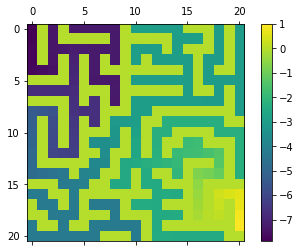

In [281]:
print("World 4 SARSA")
p, Q, _, _, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.05, n_episodes=1000, agent=4,
    step_funct = SARSA_optimization
)
plot_qmap(Q)

World 4 Q-Learning
Converged in 586 episodes. Path length: 82


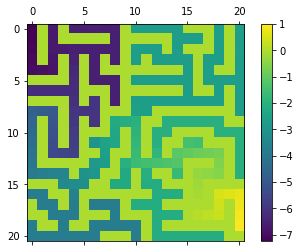

In [283]:
print("World 4 Q-Learning")
p, Q, _, _, paths, total_R, path_length = policy(
    w4, alpha=0.1, epsilon=0.05, n_episodes=1000, agent=4,
    step_funct = Q_learning_optimization
)
plot_qmap(Q)

Como vemos, son bastante similares. Se observa un valor de 0 en los obstáculos, y después vemos cómo el valor va aumentando conforme nos acercamos a la meta. Podemos ver otro ejemplo de otro mapa:

World 3 SARSA
Converged in 1059 episodes. Path length: 40


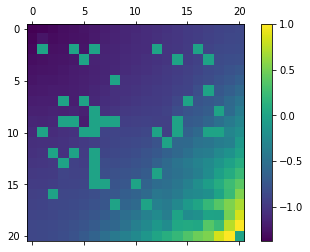

In [16]:
print("World 3 SARSA")
p, Q, _, _, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.05, gamma=0.95, n_episodes=5000, agent=4,
    step_funct = SARSA_optimization
)
plot_qmap(Q)

World 3 Q-learning
Converged in 868 episodes. Path length: 44
Improved path length: 42 (913 episodes in total)


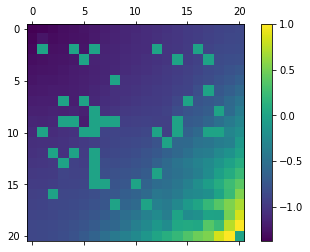

In [17]:
print("World 3 Q-learning")
p2, Q2, _, _, paths2, total_R2, path_length = policy(
    w3g, alpha=0.1, epsilon=0.05, gamma=0.95, n_episodes=5000, agent=4,
    step_funct = Q_learning_optimization
)
plot_qmap(Q)

Pasamos ahora a inspeccionar cuál de los dos métodos genera más valor. Dibujamos una gráfica con la evolución temporal (siguiendo la política final) de la función de valor Q.

In [18]:
def plot_Q_ev(policy, world, Q, agent, actions, label = None):
    state = agent.state
    vec = []

    # If it doesn't reach the goal in HxW steps, it is cycling
    for step in range(world.size[0]*world.size[1]):
        if world.is_goal(state):
            break

        action_idx = policy[state[0], state[1]]
        action = actions[action_idx]
        state, R = agent.checkAction(state, action)
        vec.append(np.max(Q[state[0], state[1], :]))

    plt.plot(vec, label = label)

In [304]:
p, Q, _, _, paths1, total_R1, path_length1 = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000, agent=4,
    step_funct = SARSA_optimization
)
p2, Q2, _, _, paths2, total_R2, path_length2 = policy(
    w3g, alpha=0.1, epsilon=0.2, n_episodes=2000, agent=4,
    step_funct = Q_learning_optimization
)

Converged in 1201 episodes. Path length: 42
Converged in 868 episodes. Path length: 42
Improved path length: 40 (908 episodes in total)


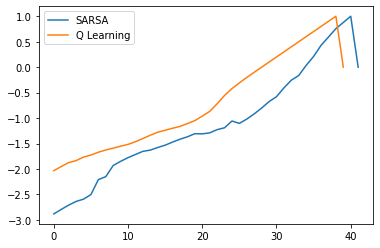

In [295]:
plot_Q_ev(p, w3g, Q, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "SARSA")
plot_Q_ev(p2, w3g, Q2, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "Q Learning")
plt.legend();

Vemos que, tal y como veíamos en el enlace que se mencionaba en el enunciado, el método de Q-learning genera más valor a lo largo de los pasos en el laberinto. Además, podemos tomar el punto en el que comienza a descender el valor como el punto de convergencia, pues significa que se ha acabado la meta. En este caso se observa que tardan ambos más o menos lo mismo. Podemos hacer otra prueba, donde vemos que se iguala un poco más el valor:

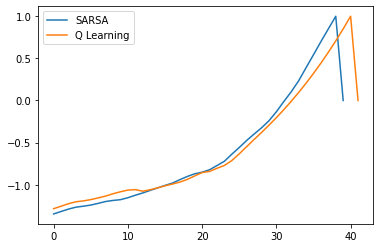

In [19]:
plot_Q_ev(p, w3g, Q, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "SARSA")
plot_Q_ev(p2, w3g, Q2, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "Q Learning")
plt.legend();

**Pregunta 3.** Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

*Respuesa.* Probamos a aumentar el valor de $\epsilon$:

In [296]:
p, Q, _, _, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.4, n_episodes=2000, agent=4,
    step_funct = SARSA_optimization
)
p2, Q2, _, _, paths, total_R, path_length = policy(
    w3g, alpha=0.1, epsilon=0.4, n_episodes=1000, agent=4,
    step_funct = Q_learning_optimization
)

Converged in 949 episodes. Path length: 42
Converged in 527 episodes. Path length: 46


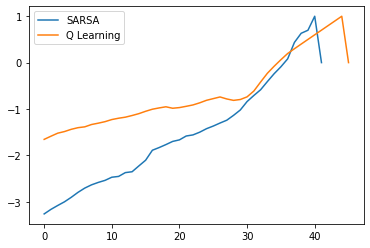

In [297]:
plot_Q_ev(p, w3g, Q, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "SARSA")
plot_Q_ev(p2, w3g, Q2, Agent4(w3g, INITIAL_STATE), ACTIONS, label = "Q Learning")
plt.legend();

Vemos que al aumentar el nivel de exploración, la diferencia de valor es más pronunciada al principio, pero se equilibra hacia el final, y llega un momento en que incluso el valor de SARSA se impone (aunque por poco y por poco tiempo). En los experimentos realizados antes, se ha observado que los algoritmos son muy sensibles a este parámetro, y que un cambio muy pequeño puede hacer que incremente mucho el tiempo de convergencia. Los valores que manejábamos y que hemos visto que funcionaban bien eran bastante bajos, del orden de 0.1 ó 0.01.

Además, para compensar el hecho de que si el valor de $\epsilon$ es alto el algoritmo fallará mucho en los últimos episodios (cuando ya debería tener una buena política), **hemos implementado un método de *decay***: el valor de $\epsilon$ va disminuyendo cada X iteraciones por un factor fijo, lo que hace que al principio podamos tener una alta exploración, pero que se vaya decrementando conforme aprendemos, para no perder demasiado de lo que ya tenemos. La implementación es muy sencilla y se puede consultar en el código de arriba, y además al probarlo ha proporcionado muy buenos resultados (conseguimos que algunos mapas que no finalizaban acabaran convergiendo aplicando el *decay*).

**Pregunta 4.** Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?

Comenzamos con el parámetro $\gamma$. Se ha observado que para los mapas más difíciles y más grandes, era mejor disminuir un poco el valor de $\gamma$ y no planear a tan largo plazo. Es el caso por ejemplo del mapa 1 mediano con el agente 3, donde con un valor de $\gamma=1$ no conseguimos que converja, mientras que con un valor de $\gamma=0.9$ sí lo hace en muy poco tiempo.

In [13]:
policy_w1m, Q, episodes, converged, paths, total_R, path_length = policy(
    w1m, alpha=0.1, epsilon=0.01, n_episodes=10000, agent=3, gamma=0.9,
    max_steps=5000, step_funct = Q_learning_optimization
)
printPolicy(w1m, policy_w1m)

Converged in 684 episodes. Path length: 48
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



Sin embargo, la mayoría de mapas funcionan mejor manteniendo $\gamma=1$, y de hecho en muchos de ellos si decrementamos el valor se pierde la convergencia.

En cuanto al *learning rate* $\alpha$, hemos visto que en general se obtienen los mejores resultados cuando tiene un valor pequeño, del orden de $0.1$. Sin embargo, en algunos mapas puntuales obtenemos una mejoría al incrementar este valor hasta $0.2$ ó incluso $0.5$.

Por último, el número de episodios es también un parámetro muy influyente. Dependiendo de la longitud del mapa, se necesitaban unos pocos cientos de episodios, o incluso miles de ellos para alcanzar la convergencia. Solo en algunos mapas excepcionales se aumentaba mucho este número, llegando a ser más de 30000 en el mapa 1 grande con el agente 1 en SARSA.

También hemos optado por implementar un parámetro `max_steps`, que controla el número máximo de pasos (actualizaciones de Q) que se pueden hacer en un mismo episodio antes de darlo por concluido, para evitar que duren demasiado. Hemos visto que en muchas ocasiones, controlar este número y fijarlo a 1000 ó 2000 hace que obtengamos mejores resultados, pues aunque quizás haga más episodios, el tiempo de ejecución total es mucho menor.

**Extra:** Como dijimos antes, hemos implementado dos agentes (el 3 y el 4) que modifican el refuerzo para intentar encontrar caminos más cortos. En algunos mapas hemos tenido éxito, mejorando la longitud del camino tras unas cuantas iteraciones más (mejorando también con respecto a los otros agentes en ese mismo mapa). Cuando tras converger la política se mejora el camino, lo mostramos en el código, indicando el número total de episodios realizados. Podemos ver un ejemplo a continuación, donde gracias a esta modificación de refuerzos el agente pasa de ignorar un túnel útil a usarlo.

In [312]:
policy_w2p, Q, episodes, converged, paths, total_R, path_length = policy(
    w2p, alpha=0.1, epsilon=0.0, n_episodes=100, agent=4,
    step_funct = SARSA_optimization, verbose=True
)
printPolicy(w2p, policy_w2p)

Episode 6
 >  >  >  v  < 
 <  #  >  v  v 
 <  <  <  v  ^ 
 v  #  #  v  v 
 ^  v  >  >  @ 

Converged in 6 episodes. Path length: 8
Improved path length: 4 (12 episodes in total)
 v  ^  ^  ^  > 
 v  #  >  ^  v 
 <  <  ^  ^  v 
 v  #  #  v  v 
 ^  v  >  >  @ 

